## Spam Detection Using Text Classification

This notebook presents a practical implementation of a text classification task focused on detecting spam emails using machine learning and deep learning methods. Based on the publicly available *Email Spam Detection Dataset*, the objective is to classify email messages as either *spam* or *ham* (legitimate).

The project demonstrates a full pipeline for processing and analyzing textual data: from preprocessing and vectorization to training various models and evaluating their performance.

### Key steps included:

- **Data Loading & Preprocessing**:  
  - Initial exploration and class distribution analysis  
  - Cleaning and normalization of text data (lowercasing, stop word removal, special characters cleanup)

- **Text Vectorization Techniques**:  
  - Application of `CountVectorizer` and `TfidfVectorizer` (Bag-of-Words and TF-IDF)  
  - Limiting feature space with `max_features` and configuring `ngram_range`

- **Pre-trained Embedding Integration**:  
  - Using models like Word2Vec, GloVe, or FastText for semantic vector representation  
  - Embedding conversion function applied to email texts

- **Model Training & Evaluation**:  
  - Logistic Regression and other ML classifiers trained on BoW and TF-IDF vectors  
  - A separate model trained on embedding-based vectors  
  - Performance metrics calculated: accuracy, AUC, and others  
  - Comparative evaluation of vectorization methods

- **Result Interpretation**:  
  - Strengths and limitations of each method  
  - Impact of embedding vs. count-based features on classification performance

This notebook provides a compact, modular framework to approach real-world spam detection and can serve as a baseline for more advanced NLP tasks.


In [ ]:
import kagglehub

dataset_path = kagglehub.dataset_download("shantanudhakadd/email-spam-detection-dataset-classification")

print("Path to dataset files:", dataset_path)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


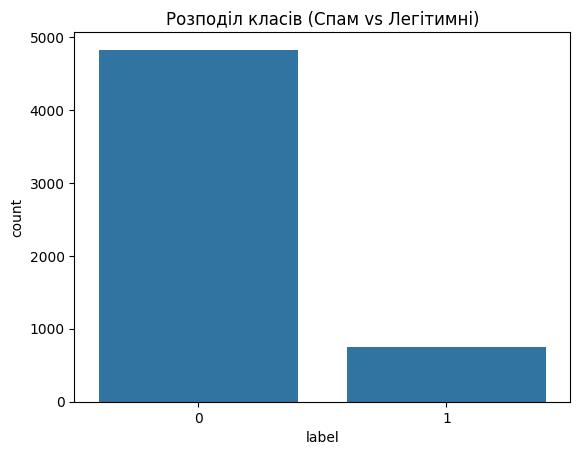

BoW та TF-IDF векторизація виконана.


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import KeyedVectors

nltk.download('stopwords')

# Завантаження даних у DataFrame
data = pd.read_csv(f"{dataset_path}/spam.csv", encoding='latin-1')
data = data.iloc[:, :2]
data.columns = ['label', 'text']

# Перетворення міток у числовий формат
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])  # spam -> 1, ham -> 0

# Візуалізація розподілу класів
sns.countplot(x=data['label'])
plt.title("Розподіл класів (Спам vs Легітимні)")
plt.show()

# Функція для очищення тексту
def preprocess_text(text):
    text = text.lower()  # Приведення до нижнього регістру
    text = re.sub(f"[{string.punctuation}]", "", text)  # Видалення пунктуації
    words = word_tokenize(text)  # Токенізація
    words = [word for word in words if word not in stopwords.words('english')]  # Видалення стоп-слів
    return " ".join(words)

# Застосування очищення тексту
data['clean_text'] = data['text'].apply(preprocess_text)

# Розбиття на навчальну та валідаційну вибірки
X_train, X_val, y_train, y_val = train_test_split(
    data['clean_text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

# Векторизація тексту (BoW)
vectorizer_bow = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_val_bow = vectorizer_bow.transform(X_val)

# Векторизація тексту (TF-IDF)
vectorizer_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_val_tfidf = vectorizer_tfidf.transform(X_val)

print("BoW та TF-IDF векторизація виконана.")


In [ ]:
# Завантаження попередньо навчених ембедингів Word2Vec
embedding_path = kagglehub.dataset_download("leadbest/googlenewsvectorsnegative300")
word2vec_model = KeyedVectors.load_word2vec_format(f"{embedding_path}/GoogleNews-vectors-negative300.bin", binary=True)

def text_to_embedding(text, model, vector_size=300):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

# Застосування ембедингів до наборів даних
X_train_w2v = np.array([text_to_embedding(text, word2vec_model) for text in X_train])
X_val_w2v = np.array([text_to_embedding(text, word2vec_model) for text in X_val])

print("BoW, TF-IDF та Word2Vec ембединг виконані.")

100%|██████████| 3.17G/3.17G [00:34<00:00, 99.5MB/s]

Extracting files...


BoW, TF-IDF та Word2Vec ембединг виконані.


In [ ]:
# Побудова та навчання моделей
# Модель Logistic Regression для BoW
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow, y_train)
y_pred_bow = lr_bow.predict(X_val_bow)
print("Точність Logistic Regression (BoW):", accuracy_score(y_val, y_pred_bow))

# Модель Logistic Regression для TF-IDF
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_val_tfidf)
print("Точність Logistic Regression (TF-IDF):", accuracy_score(y_val, y_pred_tfidf))

# Модель Random Forest для Word2Vec
rf_w2v = RandomForestClassifier()
rf_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = rf_w2v.predict(X_val_w2v)
print("Точність Random Forest (Word2Vec):", accuracy_score(y_val, y_pred_w2v))


Точність Logistic Regression (BoW): 0.9820627802690582
Точність Logistic Regression (TF-IDF): 0.9641255605381166
Точність Random Forest (Word2Vec): 0.957847533632287


In [ ]:
# Оцінка моделей
print("\nОцінка моделей:")
print("Logistic Regression (BoW):")
print(classification_report(y_val, y_pred_bow))
print("AUC:", roc_auc_score(y_val, y_pred_bow))

print("\nLogistic Regression (TF-IDF):")
print(classification_report(y_val, y_pred_tfidf))
print("AUC:", roc_auc_score(y_val, y_pred_tfidf))

print("\nRandom Forest (Word2Vec):")
print(classification_report(y_val, y_pred_w2v))
print("AUC:", roc_auc_score(y_val, y_pred_w2v))


Оцінка моделей:
Logistic Regression (BoW):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115

AUC: 0.9328859060402684

Logistic Regression (TF-IDF):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.97      0.75      0.85       149

    accuracy                           0.96      1115
   macro avg       0.97      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115

AUC: 0.8742861311434408

Random Forest (Word2Vec):
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       966
           1       0.99      0.69      0.81       149

    accuracy                    

In [ ]:
# Аналіз та інтерпретація результатів
best_model = max([
    ("Logistic Regression (BoW)", accuracy_score(y_val, y_pred_bow)),
    ("Logistic Regression (TF-IDF)", accuracy_score(y_val, y_pred_tfidf)),
    ("Random Forest (Word2Vec)", accuracy_score(y_val, y_pred_w2v))
], key=lambda x: x[1])

print("\nНайкраща модель:", best_model[0], "з точністю:", best_model[1])

print("\nПереваги та недоліки підходів:")
print("- BoW: Простий у реалізації, але не враховує значення слів у контексті.")
print("- TF-IDF: Враховує важливість слів, але все ще не враховує порядок слів.")
print("- Word2Vec: Враховує семантичне значення слів, але потребує більше ресурсів для навчання та обчислень.")



Найкраща модель: Logistic Regression (BoW) з точністю: 0.9820627802690582

Переваги та недоліки підходів:
- BoW: Простий у реалізації, але не враховує значення слів у контексті.
- TF-IDF: Враховує важливість слів, але все ще не враховує порядок слів.
- Word2Vec: Враховує семантичне значення слів, але потребує більше ресурсів для навчання та обчислень.


# Аналіз та інтерпретація результатів

1. Порівняння точності моделей

- Logistic Regression (BoW) – 98.2%

- Logistic Regression (TF-IDF) – 96.4%

- Random Forest (Word2Vec) – 95.8%

З усіх моделей найкращу точність показала Logistic Regression з BoW, тоді як методи TF-IDF та Word2Vec показали трохи гірші результати.

2. Аналіз Precision, Recall та F1-score

- BoW: Найвищі значення Precision (1.00) та Recall (0.87) для класу спаму, що вказує на хороше розпізнавання спам-листів при мінімальній кількості помилок.

- TF-IDF: Recall для спаму лише 0.75, тобто більше помилкових негативних результатів (коли спам розпізнається як легітимний лист).

- Word2Vec: Найгірший результат для спаму (Recall 0.69), що свідчить про низьку здатність моделі знаходити всі спам-листи.

3. Оцінка AUC (Area Under Curve)
- BoW: 0.93
- TF-IDF: 0.87
- Word2Vec: 0.85

AUC підтверджує, що Logistic Regression (BoW) найкраще розрізняє класи.

4. Переваги та недоліки підходів

BoW (Bag of Words)

✅ Простий у реалізації, добре працює для текстових задач

❌ Ігнорує семантику слів, збільшує розмірність

TF-IDF (Term Frequency - Inverse Document Frequency)

✅ Більш точний у врахуванні важливості слів

❌ Гірше розпізнає спам через низький Recall

Word2Vec (Попередньо навчені ембединги)

✅ Враховує семантичні зв’язки між словами

❌ Гірше працює для класифікації спаму, можливо через недостатнє узгодження з доменною лексикою

# Висновок
Найкращий результат показала Logistic Regression (BoW), тому що метод ефективно розрізняє спам-листи, навіть без глибокого врахування контексту. Для покращення моделей можна спробувати глибші нейромережі з сучаснішими ембедингами (наприклад, BERT або Transformer), які краще адаптуються до контексту текстів.